In [11]:
import os
import zipfile
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [3]:
from zipfile import ZipFile
with ZipFile('D:/archive.zip', 'r') as zipObj:
    zipObj.extractall('MWD')

In [5]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
import splitfolders

input_folder = 'C:/Users/Madhusmita Das/MWD/Multi-class Weather Dataset'
splitfolders.ratio(input_folder, output="dataset", seed=42, ratio=(0.8,0, 0.2), group_prefix=None)

Copying files: 1123 files [00:07, 149.45 files/s]


In [2]:
dataset_path='C:/Users/Madhusmita Das/dataset'

In [3]:
# Define image dimensions
img_width, img_height = 224, 224  # Standard for ResNet50

# Create data generators with train-test split (80% train, 20% test)
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_dir = os.path.join(dataset_path, 'train')  # Assuming train folder is created after splitting
test_dir = os.path.join(dataset_path, 'test')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=8,  # Adjust batch size based on GPU memory
    class_mode='categorical',  # Multi-class classification
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=8,
    class_mode='categorical',
    shuffle=False  # Maintain order for retrieval
)

Found 897 images belonging to 4 classes.
Found 226 images belonging to 4 classes.


In [4]:
import matplotlib.pyplot as plt

Epoch 1/5


C:\Users\saura\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 - 151s - 1s/step - accuracy: 0.2965 - loss: 1.3954 - val_accuracy: 0.2832 - val_loss: 1.3509
Epoch 2/5
113/113 - 111s - 980ms/step - accuracy: 0.3177 - loss: 1.3584 - val_accuracy: 0.4602 - val_loss: 1.3300
Epoch 3/5
113/113 - 111s - 986ms/step - accuracy: 0.3278 - loss: 1.3360 - val_accuracy: 0.3451 - val_loss: 1.2686
Epoch 4/5
113/113 - 110s - 973ms/step - accuracy: 0.3824 - loss: 1.2896 - val_accuracy: 0.4867 - val_loss: 1.2339
Epoch 5/5
113/113 - 109s - 968ms/step - accuracy: 0.3958 - loss: 1.2910 - val_accuracy: 0.3540 - val_loss: 1.2385
Epoch 1/10
113/113 - 160s - 1s/step - accuracy: 0.5641 - loss: 1.0629 - val_accuracy: 0.2655 - val_loss: 2.1685
Epoch 2/10
113/113 - 119s - 1s/step - accuracy: 0.7224 - loss: 0.7445 - val_accuracy: 0.2655 - val_loss: 4.1266
Epoch 3/10
113/113 - 118s - 1s/step - accuracy: 0.7748 - loss: 0.5747 - val_accuracy: 0.5133 - val_loss: 1.2826
Epoch 4/10
113/113 - 60s - 527ms/step - accuracy: 0.7993 - loss: 0.5170 - val_accuracy: 0.3673 - val_loss: 

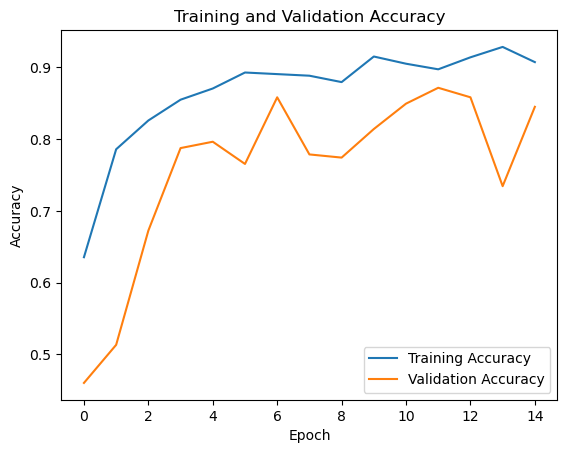

In [5]:
# Load pre-trained ResNet50 model (without top layers for feature extraction)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze pre-trained weights
base_model.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes (Cloudy, Rainy, Shiny, Sunrise)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
# First, train only the custom layers
model.fit(train_generator, epochs=5, validation_data=test_generator, verbose=2)

# Unfreeze a smaller number of layers initially
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=10, validation_data=test_generator, verbose=2)

# Gradually unfreeze more layers as needed
for layer in base_model.layers[-25:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=15, validation_data=test_generator, verbose=2)

model.save('my_trained_model_10_25.h5')

model.save('my_model_10_25.keras')

plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
# Assuming you have ground truth labels (y_true) and predicted labels (y_pred)
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1score = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1score:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 374ms/step
Precision: 0.8406
Recall: 0.8451
F1 Score: 0.8418


In [13]:
# Compute precision, recall, and F1-score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1score = f1_score(y_true, y_pred, average=None)

# Print class-wise metrics
for class_label in range(1, len(precision) + 1):
    print(f"Class {class_label}:")
    print(f"Precision: {precision[class_label - 1]:.4f}")
    print(f"Recall: {recall[class_label - 1]:.4f}")
    print(f"F1 Score: {f1score[class_label - 1]:.4f}\n")

# Print overall classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Class 1:
Precision: 0.8036
Recall: 0.7500
F1 Score: 0.7759

Class 2:
Precision: 0.9348
Recall: 1.0000
F1 Score: 0.9663

Class 3:
Precision: 0.7447
Recall: 0.6863
F1 Score: 0.7143

Class 4:
Precision: 0.8831
Recall: 0.9444
F1 Score: 0.9128

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78        60
           1       0.93      1.00      0.97        43
           2       0.74      0.69      0.71        51
           3       0.88      0.94      0.91        72

    accuracy                           0.85       226
   macro avg       0.84      0.85      0.84       226
weighted avg       0.84      0.85      0.84       226



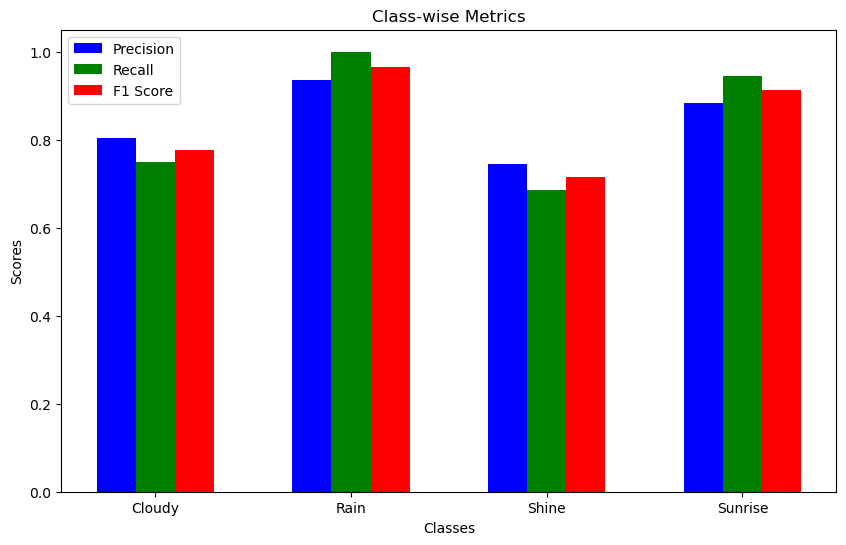

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual metrics)
classes = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
width = 0.2

# Plot bars
ax.bar(np.arange(len(classes)), precision, width, label='Precision', color='b')
ax.bar(np.arange(len(classes)) + width, recall, width, label='Recall', color='g')
ax.bar(np.arange(len(classes)) + 2 * width, f1score, width, label='F1 Score', color='r')

# Customize plot
ax.set_xticks(np.arange(len(classes)) + width)
ax.set_xticklabels(classes)
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Class-wise Metrics')
ax.legend()

# Show the plot
plt.show()


# CBIR

In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from pathlib import Path
from tensorflow.keras.models import load_model

In [6]:
model = load_model('my_trained_model_10_25.h5')

In [7]:
dataset_path ='C:/Users/Madhusmita Das/dataset/test'

# Extract The Feature Vector of All images

def extract_features(img_path, model):
  """
  Extracts features from an image using the pre-trained model.

  Args:
      img_path: Path to the image file.
      model: The pre-trained model (ResNet50 in this case).

  Returns:
      A normalized feature vector.
  """
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  features = features.flatten()
  features = normalize(features.reshape(1, -1))  # Normalize for distance calculation
  return features

all_features = {}
all_images = []

# Extract features for all images in the dataset
for class_dir in listdir(dataset_path):
    class_path = Path(dataset_path) / class_dir
    for img_file in listdir(class_path):
      img_path = Path(class_path) / img_file
      features = extract_features(img_path, model)
      all_features[img_path] = features
      all_images.append(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Query Image:


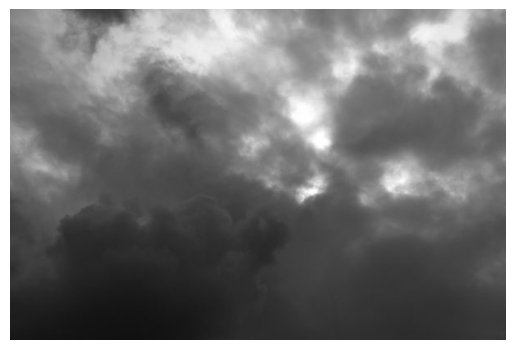

Similar Images:


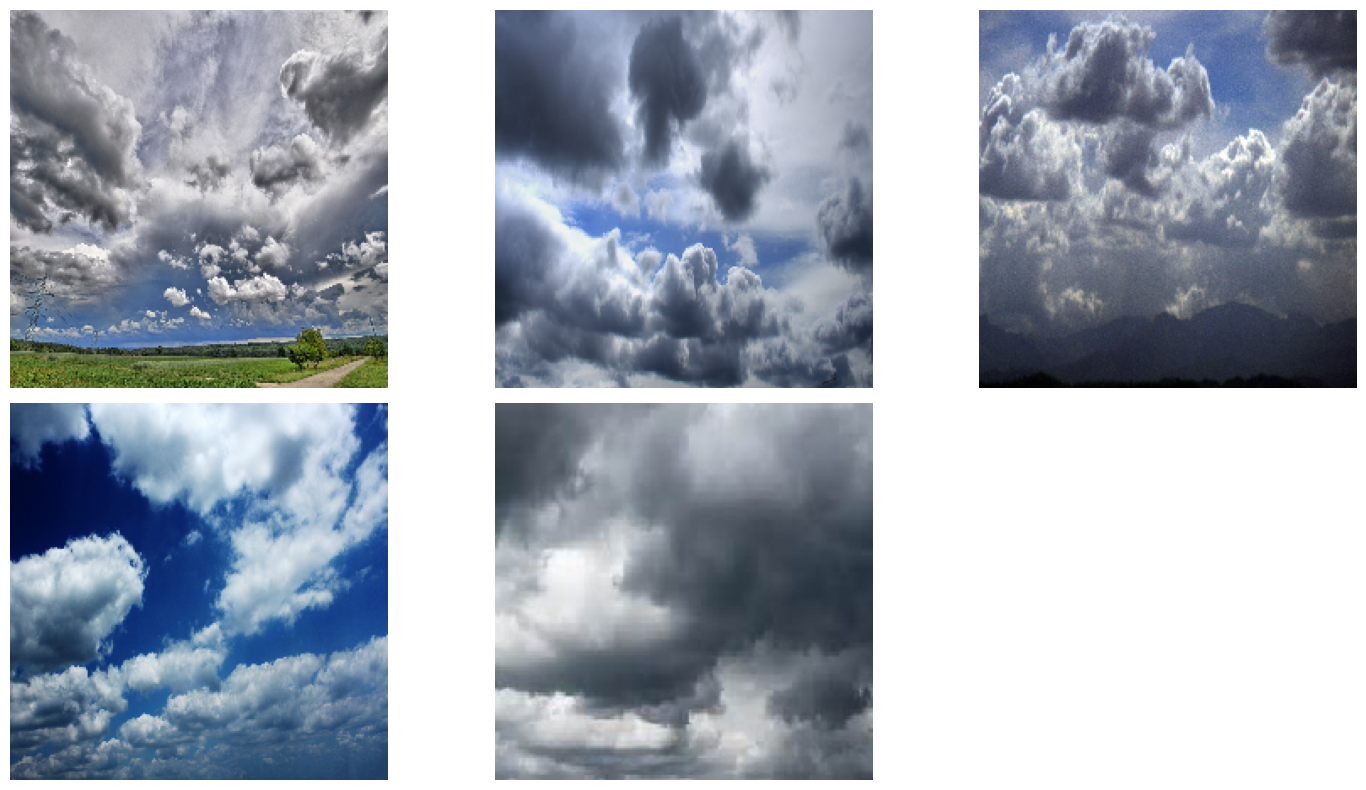

In [8]:
def retrieve_similar_images(query_path, dataset_path, model, num_results=5):
  """
  Retrieves similar images from the dataset based on the query image.

  Args:
      query_path: Path to the query image.
      dataset_path: Path to the dataset folder.
      model: The pre-trained model.
      num_results: Number of similar images to retrieve (default: 5).

  Returns:
      A list of paths to the most similar images.
  """
  query_features = extract_features(query_path, model)
  # Calculate distances between query features and all image features
  distances = {}
  for img_path, features in all_features.items():
    distance = np.linalg.norm(query_features - features)
    distances[img_path] = distance

  # Sort images by distance (ascending order)
  sorted_images = sorted(distances.items(), key=lambda item: item[1])

  # Return paths to the most similar images
  return [path for path, _ in sorted_images[:num_results]]


def display_images(image_paths):
  """
  Displays a grid of images.

  Args:
      image_paths: A list of paths to the images.
  """
  cols = 3  # Adjust the number of columns as needed
  rows = int(len(image_paths) / cols) + (len(image_paths) % cols > 0)
  plt.figure(figsize=(15, 4 * rows))
  for i, image_path in enumerate(image_paths):
    plt.subplot(rows, cols, i + 1)
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

# Load your pre-trained model (assuming it's saved as 'my_model.h5')
# model = tf.keras.models.load_model('my_model.h5')

# Get the query image path     
query_path = 'C:/Users/Madhusmita Das/dataset/train/Cloudy/cloudy1.jpg'

# Retrieve similar images
similar_images = retrieve_similar_images(query_path, dataset_path, model)

# Display the query image and similar images
print("Query Image:")
plt.imshow(plt.imread(query_path))
plt.axis('off')
plt.show()

print("Similar Images:")
display_images(similar_images)
